# Exercises Geospatial Machine Learning
In this week's exercises you are going to use a different data set. It contains a list of all renewable energy plants in Baden-Württemberg and a shape file containing all postal code areas of Germany. Both are already packed into the ZIP file that this notebook was in. 

## Prerequisites
Firstly, load all necessary libraries.

In [1]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pysal as ps
import geopandas as gpd
from sklearn import cluster
from sklearn.preprocessing import scale

sns.set(style="whitegrid")

/opt/anaconda3/lib/python3.7/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysalnext` package. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)
/opt/anaconda3/lib/python3.7/site-packages/numba/decorators.py:29: NumbaDeprecationWarning: autojit is deprecated, use jit instead, which provides the same functionality. For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-numba-autojit
  warnings.warn(NumbaDeprecationWarning(msg))


Secondly configure your file path.

In [2]:
# Adjust this to point to the right file in your computer
plants_link = "data/renewable_power_plants_bw.csv"
plz_link = 'data/PLZ5stellig.shp'

## Exercise 1 - Clustering
Create clusters for the postal code areas 89xxx based on the distribution of different plant types (*technology*) in each area. In other words, how much does one technology contribute to the total number of renewable plants in each postal code area. Show your finding using an appropriate choropleth map.

In [3]:
pc = gpd.read_file(plz_link)
pc

,PLZ99,PLZ99_N,PLZORT99,geometry
0,01067,1067,Dresden,"POLYGON ((13.71894 51.07600, 13.72122 51.07498..."
1,01069,1069,Dresden,"POLYGON ((13.74984 51.05443, 13.75115 51.05469..."
2,01097,1097,Dresden,"POLYGON ((13.72758 51.06863, 13.73200 51.07026..."
3,01099,1099,Dresden,"POLYGON ((13.82016 51.12494, 13.82555 51.12502..."
4,01109,1109,Dresden,"POLYGON ((13.75954 51.13818, 13.76404 51.13723..."
...,...,...,...,...
8265,99988,99988,Heyerode,"POLYGON ((10.30329 51.18668, 10.30012 51.18507..."
8266,99991,99991,Großengottern,"POLYGON ((10.54318 51.25693, 10.54715 51.25167..."
8267,99994,99994,Schlotheim,"POLYGON ((10.63269 51.25069, 10.63388 51.25321..."
8268,99996,99996,Mühlhausen,"POLYGON ((10.50283 51.32871, 10.50315 51.32875..."


      PLZ99  PLZ99_N       PLZORT99  \
6967  89073    89073            Ulm   
6968  89075    89075            Ulm   
6969  89077    89077            Ulm   
6970  89079    89079            Ulm   
6971  89081    89081            Ulm   
...     ...      ...            ...   
7078  89613    89613    Oberstadion   
7079  89614    89614       Öpfingen   
7080  89616    89616    Rottenacker   
7081  89617    89617  Untermarchtal   
7082  89619    89619   Unterstadion   

                                               geometry  
6967  POLYGON ((10.01732 48.41924, 10.01713 48.41908...  
6968  POLYGON ((10.02936 48.43594, 10.03190 48.43545...  
6969  POLYGON ((9.98379 48.40682, 9.98304 48.40601, ...  
6970  POLYGON ((9.97155 48.38173, 9.97054 48.38133, ...  
6971  MULTIPOLYGON (((10.03148 48.45679, 10.03491 48...  
...                                                 ...  
7078  POLYGON ((9.66646 48.20543, 9.67455 48.19899, ...  
7079  POLYGON ((9.79701 48.30545, 9.81444 48.30100, ...  
7080  POL

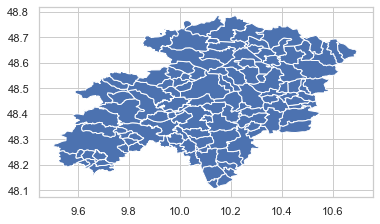

In [4]:
pcxx = pc[pc.PLZ99.str.slice(0,2) == "89"]
print(pcxx)
pcxx.plot()

In [5]:
pc89 = pcxx.set_index('PLZ99')
pc89

,PLZ99_N,PLZORT99,geometry
PLZ99,,,
89073,89073,Ulm,"POLYGON ((10.01732 48.41924, 10.01713 48.41908..."
89075,89075,Ulm,"POLYGON ((10.02936 48.43594, 10.03190 48.43545..."
89077,89077,Ulm,"POLYGON ((9.98379 48.40682, 9.98304 48.40601, ..."
89079,89079,Ulm,"POLYGON ((9.97155 48.38173, 9.97054 48.38133, ..."
89081,89081,Ulm,"MULTIPOLYGON (((10.03148 48.45679, 10.03491 48..."
...,...,...,...
89613,89613,Oberstadion,"POLYGON ((9.66646 48.20543, 9.67455 48.19899, ..."
89614,89614,Öpfingen,"POLYGON ((9.79701 48.30545, 9.81444 48.30100, ..."
89616,89616,Rottenacker,"POLYGON ((9.70602 48.22202, 9.70172 48.21944, ..."


In [6]:
plants = pd.read_csv(plants_link, sep=";")
plants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18692 entries, 0 to 18691
Data columns (total 27 columns):
commissioning_date       18692 non-null object
decommissioning_date     0 non-null float64
energy_source_level_1    18692 non-null object
energy_source_level_2    18692 non-null object
energy_source_level_3    170 non-null object
technology               18692 non-null object
electrical_capacity      18692 non-null float64
thermal_capacity         0 non-null float64
voltage_level            18692 non-null object
tso                      18692 non-null object
dso                      18692 non-null object
dso_id                   18692 non-null float64
eeg_id                   18692 non-null object
bnetza_id                0 non-null float64
federal_state            18692 non-null object
postcode                 18692 non-null int64
municipality_code        0 non-null float64
municipality             18692 non-null object
address                  2268 non-null object
address_numb

In [7]:
plants89 = plants[plants.postcode.apply(str).str.slice(0,2) == "89"]
plants89

,commissioning_date,decommissioning_date,energy_source_level_1,energy_source_level_2,energy_source_level_3,technology,electrical_capacity,thermal_capacity,voltage_level,tso,...,municipality,address,address_number,utm_zone,utm_east,utm_north,lat,lon,data_source,comment
0,1905-04-19,NaN,Renewable energy,Hydro,NaN,Run-of-river,0.04000,NaN,medium voltage,TransnetBW,...,Ulm,Blaubeurer Str.,NaN,NaN,NaN,NaN,48.43354,9.97926,TransnetBW,NaN
1,1905-06-25,NaN,Renewable energy,Hydro,NaN,Run-of-river,0.05600,NaN,medium voltage,TransnetBW,...,Erbach,Flurstück,NaN,NaN,NaN,NaN,48.31900,9.87812,TransnetBW,NaN
2,1907-01-01,NaN,Renewable energy,Hydro,NaN,Run-of-river,1.25000,NaN,medium voltage,TransnetBW,...,Ulm,Illerstr.,NaN,NaN,NaN,NaN,48.34409,9.95204,TransnetBW,NaN
3,1923-01-01,NaN,Renewable energy,Hydro,NaN,Run-of-river,1.00000,NaN,medium voltage,TransnetBW,...,Oberdischingen,Kraftwerk,NaN,NaN,NaN,NaN,48.30647,9.82992,TransnetBW,NaN
4,1923-01-01,NaN,Renewable energy,Hydro,NaN,Run-of-river,1.00000,NaN,medium voltage,TransnetBW,...,Oberdischingen,Kraftwerk,NaN,NaN,NaN,NaN,48.30647,9.82992,TransnetBW,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18687,2017-06-21,NaN,Renewable energy,Solar,NaN,Photovoltaics,0.00816,NaN,low voltage,TransnetBW,...,Neenstetten,NaN,NaN,NaN,NaN,NaN,48.54608,10.02059,TransnetBW,NaN
18688,2017-06-21,NaN,Renewable energy,Solar,NaN,Photovoltaics,0.00848,NaN,low voltage,TransnetBW,...,Hohenmemmingen,NaN,NaN,NaN,NaN,NaN,48.63201,10.23438,TransnetBW,NaN
18689,2017-06-22,NaN,Renewable energy,Solar,NaN,Photovoltaics,0.00627,NaN,low voltage,TransnetBW,...,Rammingen,NaN,NaN,NaN,NaN,NaN,48.51830,10.17396,TransnetBW,NaN
18690,2017-06-23,NaN,Renewable energy,Solar,NaN,Photovoltaics,0.00981,NaN,low voltage,TransnetBW,...,Nattheim,NaN,NaN,NaN,NaN,NaN,48.72389,10.27852,TransnetBW,NaN


In [8]:
plant_tech = pd.get_dummies(plants89["technology"])
plant_types = plant_tech.join(plants89['postcode']).groupby('postcode').sum()
plant_types_percent = (plant_types * 100.).div(plant_types.sum(axis=1), axis=0)
plant_types_percent

,Biomass and biogas,Onshore,Photovoltaics,Run-of-river,Sewage and landfill gas
postcode,,,,,
89073,0.000000,0.000000,98.076923,1.923077,0.000000
89075,0.273224,0.000000,99.726776,0.000000,0.000000
89077,1.117318,0.000000,98.324022,0.558659,0.000000
89079,1.397713,0.000000,97.712834,0.762389,0.127065
89081,0.000000,0.000000,99.860530,0.139470,0.000000
89129,0.820513,0.102564,98.871795,0.205128,0.000000
89134,0.695652,0.869565,97.565217,0.869565,0.000000
89143,2.252252,0.150150,96.846847,0.750751,0.000000
89150,1.097179,0.470219,98.432602,0.000000,0.000000


In [9]:
db = pcxx[["geometry", "PLZ99_N", "PLZORT99"]].join(plant_types_percent, on="PLZ99_N").dropna()
db

,geometry,PLZ99_N,PLZORT99,Biomass and biogas,Onshore,Photovoltaics,Run-of-river,Sewage and landfill gas
6967,"POLYGON ((10.01732 48.41924, 10.01713 48.41908...",89073,Ulm,0.000000,0.000000,98.076923,1.923077,0.000000
6968,"POLYGON ((10.02936 48.43594, 10.03190 48.43545...",89075,Ulm,0.273224,0.000000,99.726776,0.000000,0.000000
6969,"POLYGON ((9.98379 48.40682, 9.98304 48.40601, ...",89077,Ulm,1.117318,0.000000,98.324022,0.558659,0.000000
6970,"POLYGON ((9.97155 48.38173, 9.97054 48.38133, ...",89079,Ulm,1.397713,0.000000,97.712834,0.762389,0.127065
6971,"MULTIPOLYGON (((10.03148 48.45679, 10.03491 48...",89081,Ulm,0.000000,0.000000,99.860530,0.139470,0.000000
6972,"POLYGON ((10.10279 48.57172, 10.10361 48.57180...",89129,Langenau,0.820513,0.102564,98.871795,0.205128,0.000000
6973,"POLYGON ((9.79843 48.48566, 9.79814 48.48929, ...",89134,Blaustein,0.695652,0.869565,97.565217,0.869565,0.000000
6974,"POLYGON ((9.73443 48.44670, 9.75695 48.44246, ...",89143,Blaubeuren,2.252252,0.150150,96.846847,0.750751,0.000000
6975,"POLYGON ((9.69449 48.54131, 9.69680 48.53743, ...",89150,Laichingen,1.097179,0.470219,98.432602,0.000000,0.000000
6976,"POLYGON ((9.84239 48.36003, 9.84341 48.36039, ...",89155,Erbach,0.933489,0.000000,98.716453,0.350058,0.000000


In [10]:
# clustering
km5 = cluster.KMeans(n_clusters=5)
km5cls = km5.fit(db.drop(["geometry", "PLZORT99", "PLZ99_N"], axis =1).values)
km5cls

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

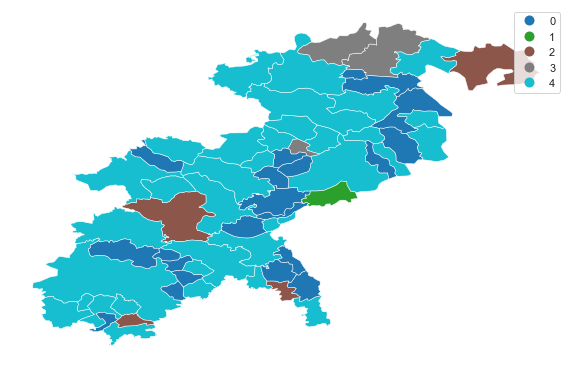

In [11]:
# plot 
f, ax = plt.subplots(1, figsize=(10,10))
with_labels = db.assign(cl=km5cls.labels_)
with_labels.plot(column="cl", categorical=True, legend=True, linewidth=0.5, edgecolor="white", ax=ax)
ax.set_axis_off()
plt.show()

## Exercise 2 - Regionalization
In this exercise your task is to find regions based on the ratio of pv plant classes which are formed by *electrical capacity* of each plant. The classes should be as follows:
* small: 0-10.00 kWp
* medium: 10.01-40.00 kWp
* large : > 40.00 kWp

Furthermore each region should contain at least 10 % of all pv plants for the areas with postal code 89xxx. The pv plant data can again be found in *renewable_power_plants_bw.csv*. Finally, you should plot the result as map.

ATTENTION: The field *electrical_capacity* is currently given in *MWp*.

In [12]:
pvp = plants89[plants89.technology == 'Photovoltaics']
pvp

,commissioning_date,decommissioning_date,energy_source_level_1,energy_source_level_2,energy_source_level_3,technology,electrical_capacity,thermal_capacity,voltage_level,tso,...,municipality,address,address_number,utm_zone,utm_east,utm_north,lat,lon,data_source,comment
13,1992-04-01,NaN,Renewable energy,Solar,NaN,Photovoltaics,0.00150,NaN,low voltage,TransnetBW,...,Heidenheim,NaN,NaN,NaN,NaN,NaN,48.66632,10.17190,TransnetBW,NaN
14,1992-11-06,NaN,Renewable energy,Solar,NaN,Photovoltaics,0.00120,NaN,low voltage,TransnetBW,...,Ulm,NaN,NaN,NaN,NaN,NaN,48.43354,9.97926,TransnetBW,NaN
15,1992-12-14,NaN,Renewable energy,Solar,NaN,Photovoltaics,0.00120,NaN,low voltage,TransnetBW,...,Ulm,NaN,NaN,NaN,NaN,NaN,48.41876,10.00639,TransnetBW,NaN
17,1993-02-01,NaN,Renewable energy,Solar,NaN,Photovoltaics,0.00450,NaN,low voltage,TransnetBW,...,Heidenheim,NaN,NaN,NaN,NaN,NaN,48.66632,10.17190,TransnetBW,NaN
18,1994-02-01,NaN,Renewable energy,Solar,NaN,Photovoltaics,0.00570,NaN,low voltage,TransnetBW,...,Heidenheim,NaN,NaN,NaN,NaN,NaN,48.71378,10.17831,TransnetBW,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18687,2017-06-21,NaN,Renewable energy,Solar,NaN,Photovoltaics,0.00816,NaN,low voltage,TransnetBW,...,Neenstetten,NaN,NaN,NaN,NaN,NaN,48.54608,10.02059,TransnetBW,NaN
18688,2017-06-21,NaN,Renewable energy,Solar,NaN,Photovoltaics,0.00848,NaN,low voltage,TransnetBW,...,Hohenmemmingen,NaN,NaN,NaN,NaN,NaN,48.63201,10.23438,TransnetBW,NaN
18689,2017-06-22,NaN,Renewable energy,Solar,NaN,Photovoltaics,0.00627,NaN,low voltage,TransnetBW,...,Rammingen,NaN,NaN,NaN,NaN,NaN,48.51830,10.17396,TransnetBW,NaN
18690,2017-06-23,NaN,Renewable energy,Solar,NaN,Photovoltaics,0.00981,NaN,low voltage,TransnetBW,...,Nattheim,NaN,NaN,NaN,NaN,NaN,48.72389,10.27852,TransnetBW,NaN


In [13]:
def labeling (row):
   if row["electrical_capacity"] <= 10.0/1000:
      return "small"
   elif row["electrical_capacity"] <= 40.00/1000:
      return "medium"
   else:
      return "large"
    
pvp.loc[:,'pv_class'] = pvp.apply (lambda row: labeling(row),axis=1)    
pvp

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,commissioning_date,decommissioning_date,energy_source_level_1,energy_source_level_2,energy_source_level_3,technology,electrical_capacity,thermal_capacity,voltage_level,tso,...,address,address_number,utm_zone,utm_east,utm_north,lat,lon,data_source,comment,pv_class
13,1992-04-01,NaN,Renewable energy,Solar,NaN,Photovoltaics,0.00150,NaN,low voltage,TransnetBW,...,NaN,NaN,NaN,NaN,NaN,48.66632,10.17190,TransnetBW,NaN,small
14,1992-11-06,NaN,Renewable energy,Solar,NaN,Photovoltaics,0.00120,NaN,low voltage,TransnetBW,...,NaN,NaN,NaN,NaN,NaN,48.43354,9.97926,TransnetBW,NaN,small
15,1992-12-14,NaN,Renewable energy,Solar,NaN,Photovoltaics,0.00120,NaN,low voltage,TransnetBW,...,NaN,NaN,NaN,NaN,NaN,48.41876,10.00639,TransnetBW,NaN,small
17,1993-02-01,NaN,Renewable energy,Solar,NaN,Photovoltaics,0.00450,NaN,low voltage,TransnetBW,...,NaN,NaN,NaN,NaN,NaN,48.66632,10.17190,TransnetBW,NaN,small
18,1994-02-01,NaN,Renewable energy,Solar,NaN,Photovoltaics,0.00570,NaN,low voltage,TransnetBW,...,NaN,NaN,NaN,NaN,NaN,48.71378,10.17831,TransnetBW,NaN,small
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18687,2017-06-21,NaN,Renewable energy,Solar,NaN,Photovoltaics,0.00816,NaN,low voltage,TransnetBW,...,NaN,NaN,NaN,NaN,NaN,48.54608,10.02059,TransnetBW,NaN,small
18688,2017-06-21,NaN,Renewable energy,Solar,NaN,Photovoltaics,0.00848,NaN,low voltage,TransnetBW,...,NaN,NaN,NaN,NaN,NaN,48.63201,10.23438,TransnetBW,NaN,small
18689,2017-06-22,NaN,Renewable energy,Solar,NaN,Photovoltaics,0.00627,NaN,low voltage,TransnetBW,...,NaN,NaN,NaN,NaN,NaN,48.51830,10.17396,TransnetBW,NaN,small
18690,2017-06-23,NaN,Renewable energy,Solar,NaN,Photovoltaics,0.00981,NaN,low voltage,TransnetBW,...,NaN,NaN,NaN,NaN,NaN,48.72389,10.27852,TransnetBW,NaN,small


In [14]:
pv_classes = pd.get_dummies(pvp['pv_class'])
pv_types = pv_classes.join(pvp['postcode']).groupby('postcode').sum()
pv_types_percentage = (pv_types * 100.).div(pv_types.sum(axis=1), axis=0)
pv_types_percentage

,large,medium,small
postcode,,,
89073,19.607843,41.176471,39.215686
89075,0.273973,19.452055,80.273973
89077,7.386364,28.409091,64.204545
89079,7.022107,34.330299,58.647594
89081,7.960894,36.173184,55.865922
89129,6.120332,40.871369,53.008299
89134,5.525847,34.937611,59.536542
89143,7.906977,42.790698,49.302326
89150,8.757962,35.828025,55.414013


In [15]:
zrt = pc89[['geometry', 'PLZ99_N', 'PLZORT99']].join(pv_types_percentage,on='PLZ99_N').dropna()
zrt.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 60 entries, 89073 to 89619
Data columns (total 6 columns):
geometry    60 non-null geometry
PLZ99_N     60 non-null int64
PLZORT99    60 non-null object
large       60 non-null float64
medium      60 non-null float64
small       60 non-null float64
dtypes: float64(3), geometry(1), int64(1), object(1)
memory usage: 3.3+ KB


In [16]:
zrt.to_file('tmp')
qw = ps.queen_from_shapefile('tmp/tmp.shp', idVariable='PLZ99_N')
# NOTE: this might not work on Windows
! rm -r tmp
qw.weights

{89073: [1.0, 1.0],
 89075: [1.0, 1.0, 1.0, 1.0, 1.0],
 89077: [1.0, 1.0, 1.0, 1.0],
 89081: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 89275: [1.0, 1.0, 1.0],
 89134: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 89079: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 89143: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 89155: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 89171: [1.0, 1.0, 1.0],
 89185: [1.0, 1.0, 1.0, 1.0],
 89195: [1.0, 1.0, 1.0, 1.0, 1.0],
 89129: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 89160: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 89179: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 89177: [1.0, 1.0, 1.0, 1.0],
 89182: [1.0, 1.0, 1.0, 1.0],
 89189: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 89192: [1.0, 1.0, 1.0],
 89542: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 89547: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 89150: [1.0, 1.0, 1.0, 1.0, 1.0],
 89180: [1.0, 1.0, 1.0],
 89601: [1.0, 1.0, 1.0, 1.0, 1.0],
 89188: [1.0, 1.0, 1.0],
 89584: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 89604: [1

In [17]:
ps.region.Maxp?
# minimum number of plants per region
n_rev = pvp.groupby('postcode').count()['technology']
thr = np.round(0.1 * n_rev.sum())
thr

1838.0

In [ ]:
# set seed for reproducibility
np.random.seed(1234)

z = zrt.drop(['geometry', 'PLZ99_N','PLZORT99'], axis=1).values
# Compute the regions
maxp = ps.region.Maxp(qw, z, thr, n_rev.values[:, None], initial=1000)

In [ ]:
# plot the regions
lbls = pd.Series(maxp.area2region).reindex(zrt['PLZ99_N'])
f, ax = plt.subplots(1, figsize=(9, 9))

regions = zrt.assign(cl=lbls.values)
regions.plot(column='cl', categorical=True, legend=True, linewidth=0.1, edgecolor='white', ax=ax)

ax.set_axis_off()

plt.show()

In [ ]:
zrt[['small','medium','large']].groupby(lbls.values).mean().T